## Basic Intro to Quantum ML

- The idea is to explore the potential applications of quantum computing in machine learning

### Model

- We'll be looking at using a QCNN (Quantum CNN) for classifying MNIST images. This is a fairly simple dataset, which makes it perfect for to test the efficacy of the Quantum Algorithm. In order to compare the model's performance, we will compare it to [LeNet-5]("http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf"). This model was released in 1998 by Yann LeCun. It was one of the earliest convnets used for image recognition, so it seems reasonable to consider it as a baseline for comparison to the QCNN, which is still in its infancy. `[we can't do this comparison yet]`

- Additionally, we will compare both a Quantum and Classical Autoencoder


In [18]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim  # used for optimization libraries (SGD, Adam, etc)
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # used for progress bars
import matplotlib.pyplot as plt

torch.manual_seed(17)  # computers a (pseudo) random, so specifying a seed allows for reproducibility
None

## Initial Steps (for classical models)

- Define hyperparams and util functions
- Create models
- Create dataloaders
- Train models


In [19]:
# Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3
nb_channels = 16
embedding_dim = 10
batch_size = 64
nb_epochs = 25

In [20]:
# Utils
def plot_imgs(input, output):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(input, cmap="gray")
    ax[0].set_title("Input")
    ax[1].imshow(output, cmap="gray")
    ax[1].set_title("Output")
    plt.show()


def get_encoded_decoded(model, input):
    z = model.encode(input)
    output = model.decode(z)
    return z, output


def train_autoencoder(model, train_loader, optimizer, nb_epochs):
    for epoch in range(nb_epochs):
        acc_loss = 0
        for batch_idx, data in enumerate(tqdm(train_loader)):
            # send the data to cuda, if possible
            data = data.to(DEVICE)
            output = model(data)
            loss = 0.5 * (output - data).pow(2).sum() / data.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {acc_loss:.4f}")

In [21]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=120,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)

        return x

In [22]:
# we need to reduce the size of the image, so instead of cropping we can use an autoencoder ro reduce the dimensionality
# note: PCA is a linear autoencoder


class ChannelAttention(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16) -> None:
        super().__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.size()) == 3:
            b, c, _ = x.size()
        else:
            b, c, _, _ = x.size()
        avg_pool = self.avg_pool(x).view(b, c)
        max_pool = self.max_pool(x).view(b, c)
        return self.sigmoid(self.fc(avg_pool) + self.fc(max_pool)).view(b, c, 1, 1)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size: int = 7) -> None:
        super().__init__()

        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_pool, max_pool], dim=1)
        return self.sigmoid(self.conv(x))


class CBAM(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16) -> None:
        super().__init__()

        self.channel_attn = ChannelAttention(in_channels, reduction)
        self.spatial_attn = SpatialAttention()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.channel_attn(x) * x
        x = self.spatial_attn(x) * x
        return x


# CBAM paper - https://arxiv.org/abs/1807.06521
# CBAM is a module that uses both channel and spatial attention to improve the performance of a model


class AutoEncoder(nn.Module):
    def __init__(self, nb_channels: int, embedding_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=5),  # to 24x24 - we are using MNIST
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),  # to 20x20
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # to 9x9
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # to 4x4
            nn.GELU(),
            nn.Conv2d(nb_channels, embedding_dim, kernel_size=4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, nb_channels, kernel_size=4),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # from 4x4
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # from 9x9
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),  # from 20x20
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),  # from 24x24
        )

        # print the number of parameters
        print(f"number of parameters: {(sum(p.numel() for p in self.parameters())):,}")

    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

    def decode(self, z):
        return self.decoder(z.view(z.size(0), -1, 1, 1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


"""
Why put the CBAM module directly after the conv layer?
  - well, from theory, we see that the typical conv-batchnorm-relu is a good combination so it makes sense to put the CBAM module after the conv layer.
    this block (conv-batchnorm-relu) make sense, because relu clips the values so you are essnetially losing some info. we would ideally want to learn
    what to pay "attention" to before we clip the values. that said, we're also swapping relu for gelu because it has been shown to perform better (it does in this). 
"""


class AutoEncoderCBAM(nn.Module):
    def __init__(self, nb_channels: int, embedding_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=5),  # to 24x24 - we are using MNIST
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),  # to 20x20
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # to 9x9
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # to 4x4
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, embedding_dim, kernel_size=4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, nb_channels, kernel_size=4),
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # from 4x4
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # from 9x9
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),  # from 20x20
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),  # from 24x24
        )

        # print the number of parameters
        print(f"number of parameters: {(sum(p.numel() for p in self.parameters())):,}")

    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

    def decode(self, z):
        return self.decoder(z.view(z.size(0), -1, 1, 1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
ae_train_set = datasets.MNIST("data/mnist/", train=True, download=True)
ae_train_dataset = ae_train_set.data.view(-1, 1, 28, 28).float()
mu, std = ae_train_dataset.mean(), ae_train_dataset.std()
ae_train_dataset.sub_(mu).div_(std)
ae_train_loader = DataLoader(dataset=ae_train_dataset, batch_size=batch_size, shuffle=True)

ae_test_set = datasets.MNIST("data/mnist/", train=False, download=True)
ae_test_dataset = ae_test_set.data.view(-1, 1, 28, 28).float()
ae_test_dataset.sub_(mu).div_(std)
None  # prevent it from printing the last line

In [24]:
autoencoder = AutoEncoder(nb_channels=nb_channels, embedding_dim=embedding_dim)
autoencoder = autoencoder.to(DEVICE)

number of parameters: 30,633


In [25]:
autoencoder_cbam = AutoEncoderCBAM(nb_channels=nb_channels, embedding_dim=embedding_dim)
autoencoder_cbam = autoencoder_cbam.to(DEVICE)

number of parameters: 35,513


In [26]:
get_optimizer = lambda model: optim.AdamW(model.parameters(), lr=learning_rate)
ae_optimizer = get_optimizer(autoencoder)
cbam_ae_optimizer = get_optimizer(autoencoder_cbam)

In [27]:
train_autoencoder(autoencoder, ae_train_loader, ae_optimizer, nb_epochs)

100%|██████████| 938/938 [00:04<00:00, 221.50it/s]


Epoch 1, Loss: 127801.9413


100%|██████████| 938/938 [00:03<00:00, 250.76it/s]


Epoch 2, Loss: 85652.1259


100%|██████████| 938/938 [00:03<00:00, 305.01it/s]


Epoch 3, Loss: 79784.3744


100%|██████████| 938/938 [00:03<00:00, 240.76it/s]


Epoch 4, Loss: 76625.8456


100%|██████████| 938/938 [00:03<00:00, 271.47it/s]


Epoch 5, Loss: 74287.5844


100%|██████████| 938/938 [00:02<00:00, 314.48it/s]


Epoch 6, Loss: 72635.0814


100%|██████████| 938/938 [00:03<00:00, 258.91it/s]


Epoch 7, Loss: 71211.9679


100%|██████████| 938/938 [00:03<00:00, 249.01it/s]


Epoch 8, Loss: 70045.0054


100%|██████████| 938/938 [00:03<00:00, 301.16it/s]


Epoch 9, Loss: 69147.3161


100%|██████████| 938/938 [00:03<00:00, 259.13it/s]


Epoch 10, Loss: 68225.2899


100%|██████████| 938/938 [00:03<00:00, 252.00it/s]


Epoch 11, Loss: 67507.6807


100%|██████████| 938/938 [00:02<00:00, 328.55it/s]


Epoch 12, Loss: 66803.0481


100%|██████████| 938/938 [00:03<00:00, 256.01it/s]


Epoch 13, Loss: 66224.0251


100%|██████████| 938/938 [00:03<00:00, 249.89it/s]


Epoch 14, Loss: 65668.1894


100%|██████████| 938/938 [00:03<00:00, 299.62it/s]


Epoch 15, Loss: 65199.7757


100%|██████████| 938/938 [00:03<00:00, 250.81it/s]


Epoch 16, Loss: 64780.8493


100%|██████████| 938/938 [00:03<00:00, 257.02it/s]


Epoch 17, Loss: 64348.7449


100%|██████████| 938/938 [00:02<00:00, 322.83it/s]


Epoch 18, Loss: 63916.6918


100%|██████████| 938/938 [00:03<00:00, 258.00it/s]


Epoch 19, Loss: 63595.6800


100%|██████████| 938/938 [00:03<00:00, 274.04it/s]


Epoch 20, Loss: 63281.8138


100%|██████████| 938/938 [00:03<00:00, 310.80it/s]


Epoch 21, Loss: 63065.3970


100%|██████████| 938/938 [00:03<00:00, 239.14it/s]


Epoch 22, Loss: 62672.1620


100%|██████████| 938/938 [00:03<00:00, 276.58it/s]


Epoch 23, Loss: 62393.3360


100%|██████████| 938/938 [00:02<00:00, 317.77it/s]


Epoch 24, Loss: 62221.2477


100%|██████████| 938/938 [00:03<00:00, 268.64it/s]

Epoch 25, Loss: 61965.4440


In [28]:
train_autoencoder(autoencoder_cbam, ae_train_loader, cbam_ae_optimizer, nb_epochs)

100%|██████████| 938/938 [00:09<00:00, 96.62it/s] 


Epoch 1, Loss: 163528.8273


100%|██████████| 938/938 [00:09<00:00, 99.28it/s] 


Epoch 2, Loss: 95539.9600


100%|██████████| 938/938 [00:09<00:00, 95.33it/s] 


Epoch 3, Loss: 86580.5702


100%|██████████| 938/938 [00:09<00:00, 97.28it/s] 


Epoch 4, Loss: 81785.3907


100%|██████████| 938/938 [00:09<00:00, 94.58it/s] 


Epoch 5, Loss: 78274.7709


100%|██████████| 938/938 [00:09<00:00, 99.44it/s] 


Epoch 6, Loss: 75746.7596


100%|██████████| 938/938 [00:09<00:00, 101.34it/s]


Epoch 7, Loss: 73554.7382


100%|██████████| 938/938 [00:09<00:00, 99.51it/s] 


Epoch 8, Loss: 71922.3345


100%|██████████| 938/938 [00:09<00:00, 97.40it/s] 


Epoch 9, Loss: 70585.8011


100%|██████████| 938/938 [00:10<00:00, 93.61it/s] 


Epoch 10, Loss: 69305.7524


100%|██████████| 938/938 [00:09<00:00, 93.95it/s] 


Epoch 11, Loss: 68321.0379


100%|██████████| 938/938 [00:09<00:00, 96.08it/s] 


Epoch 12, Loss: 67408.7743


100%|██████████| 938/938 [00:10<00:00, 93.55it/s] 


Epoch 13, Loss: 66672.2046


100%|██████████| 938/938 [00:10<00:00, 88.09it/s] 


Epoch 14, Loss: 65942.9963


100%|██████████| 938/938 [00:10<00:00, 91.00it/s] 


Epoch 15, Loss: 65327.1643


100%|██████████| 938/938 [00:10<00:00, 92.30it/s] 


Epoch 16, Loss: 64798.5159


100%|██████████| 938/938 [00:09<00:00, 97.06it/s] 


Epoch 17, Loss: 64208.8339


100%|██████████| 938/938 [00:10<00:00, 91.94it/s] 


Epoch 18, Loss: 63750.7441


100%|██████████| 938/938 [00:09<00:00, 98.04it/s] 


Epoch 19, Loss: 63325.3289


100%|██████████| 938/938 [00:09<00:00, 98.40it/s] 


Epoch 20, Loss: 62952.0202


100%|██████████| 938/938 [00:10<00:00, 92.53it/s] 


Epoch 21, Loss: 62577.5787


100%|██████████| 938/938 [00:10<00:00, 92.25it/s] 


Epoch 22, Loss: 62244.6306


100%|██████████| 938/938 [00:09<00:00, 95.91it/s] 


Epoch 23, Loss: 61910.2071


100%|██████████| 938/938 [00:10<00:00, 92.95it/s] 


Epoch 24, Loss: 61655.7092


100%|██████████| 938/938 [00:09<00:00, 94.29it/s] 

Epoch 25, Loss: 61364.5329


In [29]:
input = ae_test_dataset[56].to(DEVICE)

# Encode / decode
z, output = get_encoded_decoded(autoencoder, input)
z_cbam, output_cbam = get_encoded_decoded(autoencoder_cbam, input.unsqueeze(0))

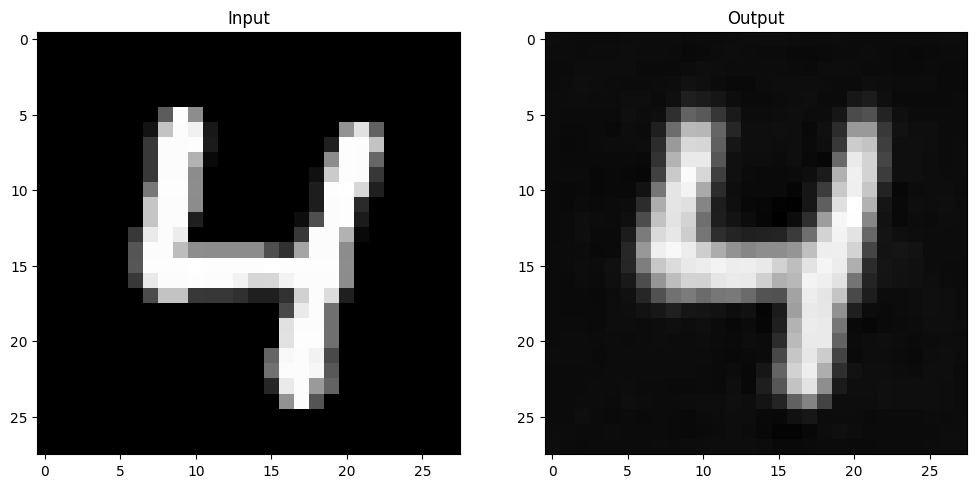

In [30]:
plot_imgs(input.cpu().detach().numpy().squeeze(), output.cpu().detach().numpy().squeeze())

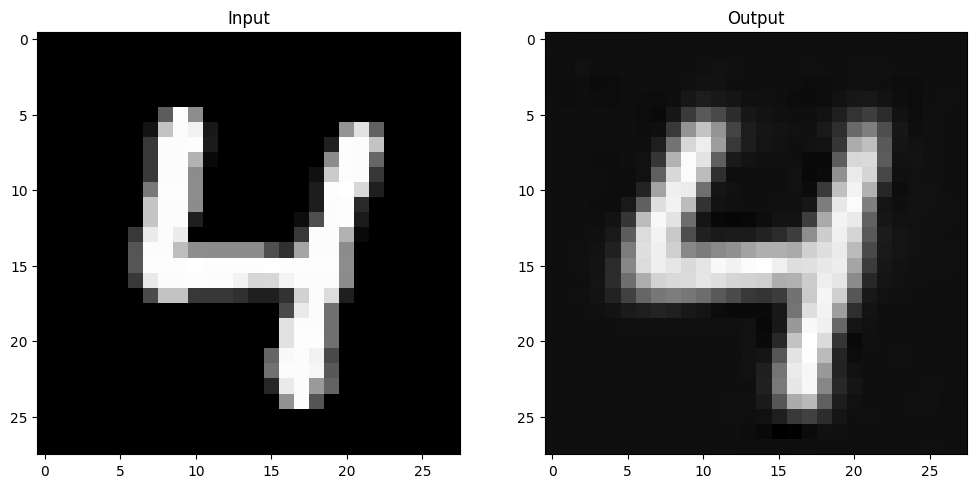

In [31]:
plot_imgs(input.cpu().detach().numpy().squeeze(), output_cbam.cpu().detach().numpy().squeeze())

## Quantum Models


### QCNN


In [32]:
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 17

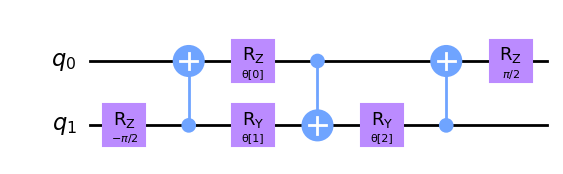

In [33]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

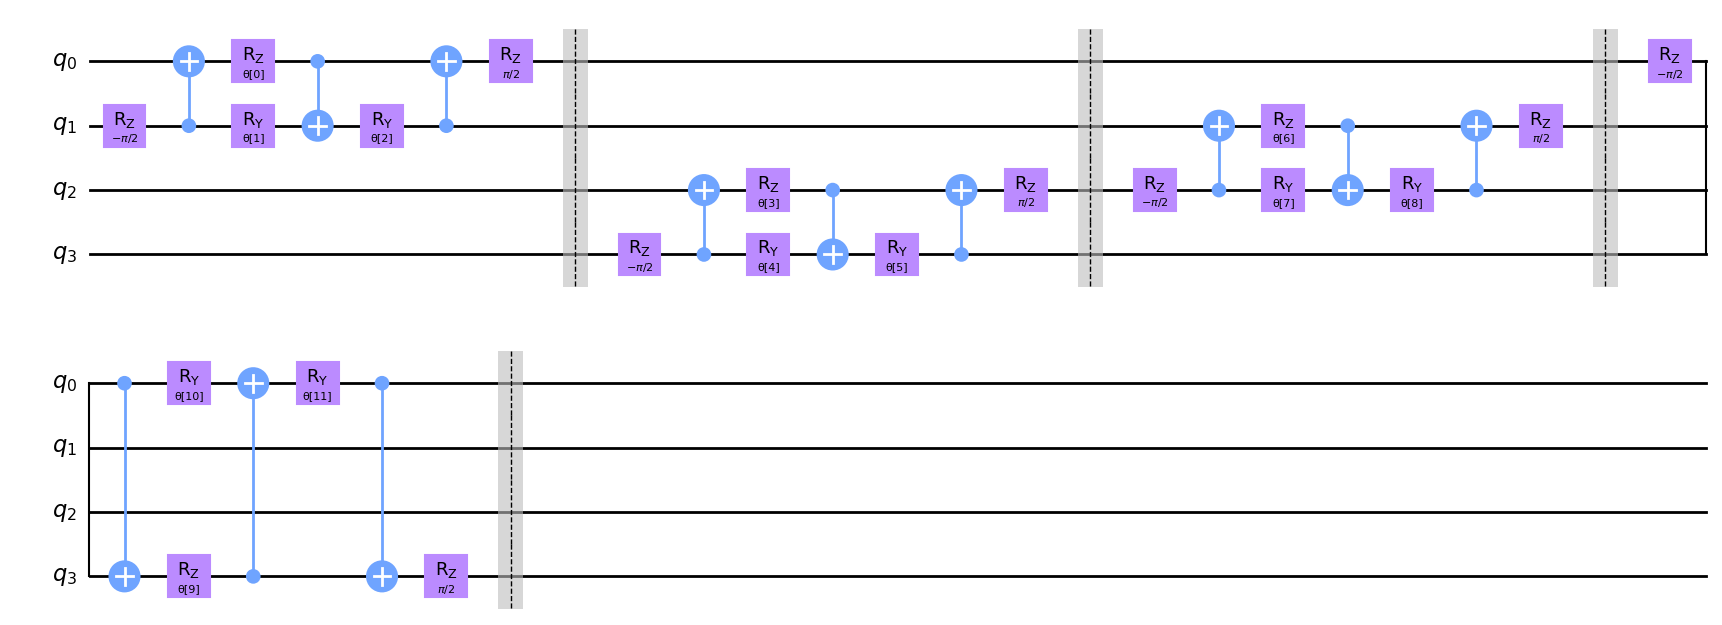

In [34]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

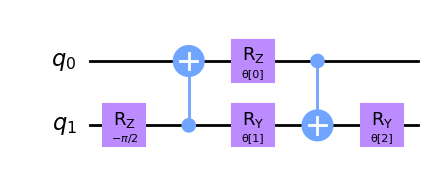

In [35]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

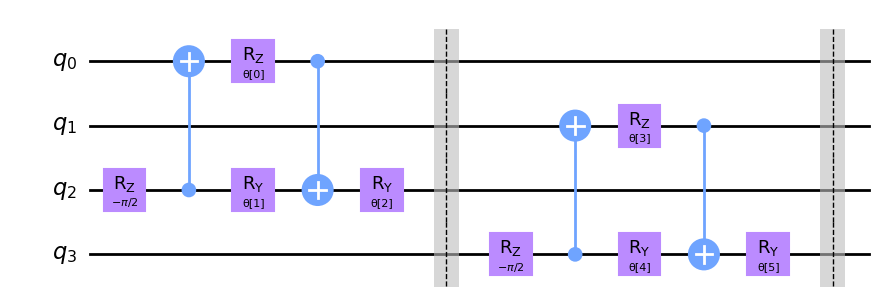

In [36]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [61]:
# Takes too long to train QCNN

qcnn_train_set = datasets.MNIST("data/mnist/", train=True, transform=transforms.ToTensor(), download=True)
qcnn_test_set = datasets.MNIST("data/mnist/", train=False, transform=transforms.ToTensor(), download=True)

X_train, X_test, y_train, y_test = (
    qcnn_train_set.data,
    qcnn_test_set.data,
    qcnn_train_set.targets,
    qcnn_test_set.targets,
)

N = 100
set_1 = 3
set_1_vals_train = np.where(y_train == set_1)[0]
set_1_vals_test = np.where(y_test == set_1)[0]
set_2 = 6
set_2_vals_train = np.where(y_train == set_2)[0]
set_2_vals_test = np.where(y_test == set_2)[0]

encode = lambda x: autoencoder_cbam.encode(x.to(DEVICE)).detach().cpu().numpy()


X_train = X_train.unsqueeze(1).reshape(-1, 1, 28, 28).to(torch.float32)
X_train = np.concatenate((X_train[set_1_vals_train][: N // 2], X_train[set_2_vals_train][: N // 2]))
y_train = np.concatenate((y_train[set_1_vals_train][: N // 2], y_train[set_2_vals_train][: N // 2]))
X_test = X_test.unsqueeze(1).reshape(-1, 1, 28, 28).to(torch.float32)
X_test = np.concatenate((X_test[set_1_vals_test][: N // 2], X_test[set_2_vals_test][: N // 2]))
y_test = np.concatenate((y_test[set_1_vals_test][: N // 2], y_test[set_2_vals_test][: N // 2]))


X_train_encoded = encode(torch.Tensor(X_train))
X_test_encoded = encode(torch.Tensor(X_test))

X_train_encoded, y_train = shuffle(X_train_encoded, y_train, random_state=17)
X_test_encoded, y_test = shuffle(X_test_encoded, y_test, random_state=17)

# labels/targets need to be 1 and -1
y_train[y_train == 3] = -1
y_train[y_train == 6] = 1
y_test[y_test == 3] = -1
y_test[y_test == 6] = 1

In [8]:
# def generate_dataset(num_images):
#     images = []
#     labels = []
#     hor_array = np.zeros((6, 8))
#     ver_array = np.zeros((4, 8))

#     j = 0
#     for i in range(0, 7):
#         if i != 3:
#             hor_array[j][i] = np.pi / 2
#             hor_array[j][i + 1] = np.pi / 2
#             j += 1

#     j = 0
#     for i in range(0, 4):
#         ver_array[j][i] = np.pi / 2
#         ver_array[j][i + 4] = np.pi / 2
#         j += 1

#     for n in range(num_images):
#         rng = algorithm_globals.random.integers(0, 2)
#         if rng == 0:
#             labels.append(-1)
#             random_image = algorithm_globals.random.integers(0, 6)
#             images.append(np.array(hor_array[random_image]))
#         elif rng == 1:
#             labels.append(1)
#             random_image = algorithm_globals.random.integers(0, 4)
#             images.append(np.array(ver_array[random_image]))

#         # Create noise
#         for i in range(8):
#             if images[-1][i] == 0:
#                 images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
#     return images, labels

In [9]:
# images, labels = generate_dataset(100)

# train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=17)

In [62]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

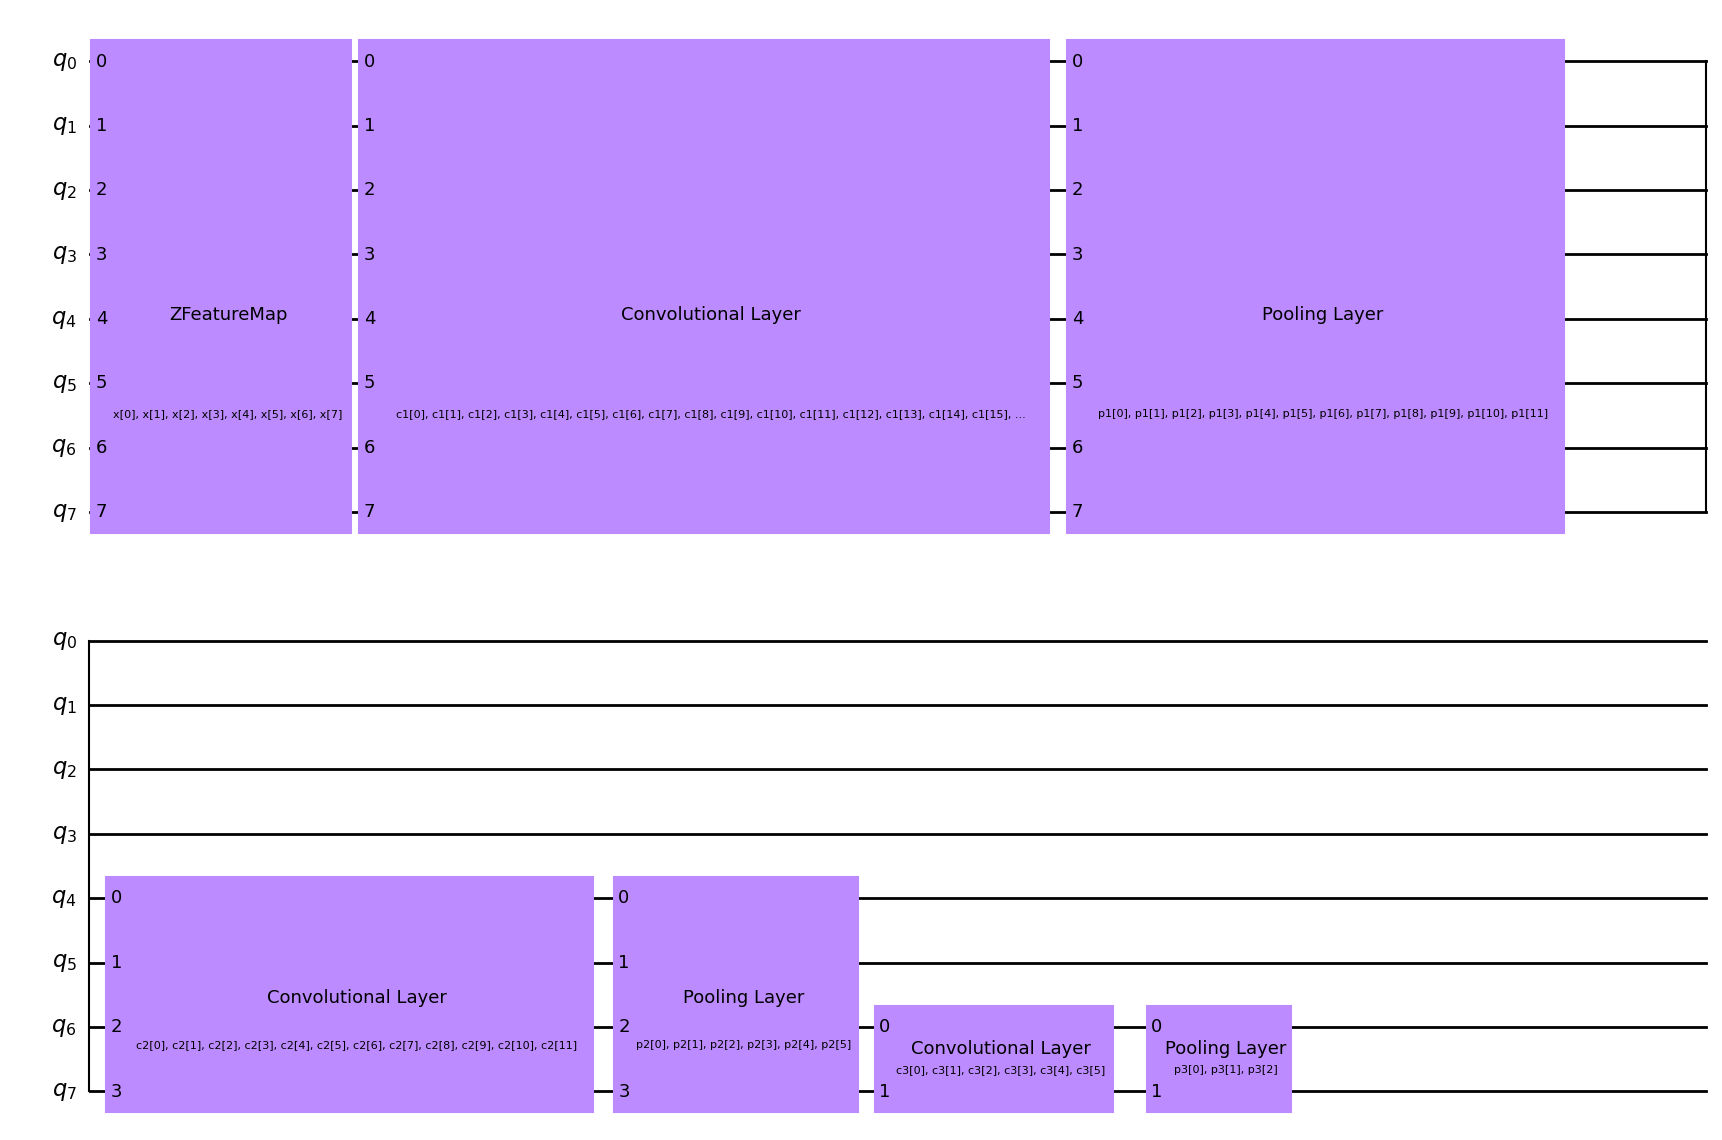

In [63]:
circuit.draw("mpl", style="clifford")

In [64]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [65]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
)

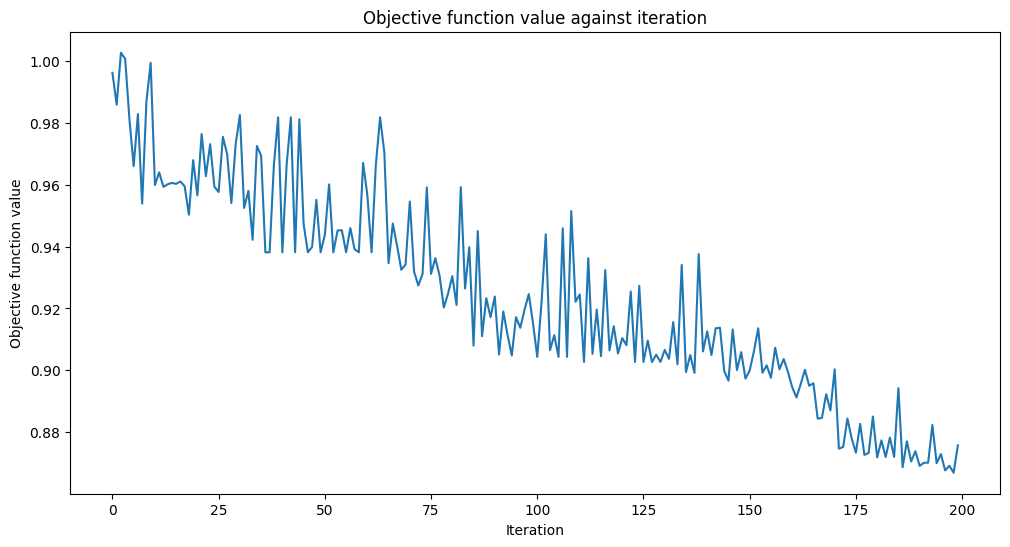

In [66]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
# classifier.fit(X_train_encoded, y_train)

x = np.asarray(X_train_encoded)
y = np.asarray(y_train)
classifier.fit(x, y)

In [67]:
x = np.asarray(X_test_encoded)
y = np.asarray(y_test)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 54.0%


### Quantum Autoencoder


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 17

In [ ]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

In [ ]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

In [ ]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(8, 4)

        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = algorithm_globals.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(8, 4)

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = algorithm_globals.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, __ = get_dataset_digits(50, False)

In [ ]:
num_latent = 3
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw(output="mpl", style="clifford")

In [ ]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [ ]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

In [ ]:
import time

opt = COBYLA(maxiter=150)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(
    fun=cost_func_digits, x0=np.random.random(30)
)  # x0 - initilize the model at a random 'location'
# because the inherent stochasticity with the (pseudo) random number (array in this case) generator, the model's performance will vary greatly
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

In [ ]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_digits(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 4))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 4))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv, cmap="gray")
    ax1.set_title("Input Data")
    ax2.imshow(output_sv, cmap="gray")
    ax2.set_title("Output Data")
    plt.show()

In [ ]:
padded_train_images = torch.Tensor(
    np.array(
        [
            nn.functional.pad(torch.tensor(train_image), (1, 3)).reshape(6, 6).unsqueeze(0)
            for train_image in train_images
        ]
    )
)

In [ ]:
padded_train_images.shape

In [ ]:
mu, std = padded_train_images.mean(), padded_train_images.std()
padded_train_images.sub_(mu).div_(std)
padded_train_images_loader = DataLoader(dataset=padded_train_images, batch_size=8, shuffle=True)

In [ ]:
class SmallAutoEncoder(nn.Module):
    def __init__(self, nb_channels: int, embedding_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=3, padding=1),  # to 6x6
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, padding=1),  # to 6x6
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, padding=1),  # to 6x6
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3),  # to 4x4
            nn.GELU(),
            nn.Conv2d(nb_channels, embedding_dim, kernel_size=4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, nb_channels, kernel_size=4),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3),  # from 4x4
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=1, stride=1),  # from 6x6
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=1, stride=1),  # from 6x6
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=1, stride=1),  # from 6x6
        )

        # print the number of parameters
        print(f"number of parameters: {(sum(p.numel() for p in self.parameters())):,}")

    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

    def decode(self, z):
        return self.decoder(z.view(z.size(0), -1, 1, 1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
small_autoencoder = SmallAutoEncoder(nb_channels=1, embedding_dim=5)
small_autoencoder = small_autoencoder.to(DEVICE)

In [ ]:
start = time.time()
train_autoencoder(small_autoencoder, padded_train_images_loader, get_optimizer(small_autoencoder), nb_epochs=1_000)
elapsed = time.time() - start

In [ ]:
print(f"Fit in {elapsed:0.2f} seconds")

In [ ]:
input = padded_train_images[7].to(DEVICE)
z, output = get_encoded_decoded(small_autoencoder, input)
plot_imgs(input.cpu().detach().numpy().squeeze(), output.cpu().detach().numpy().squeeze())

We see that the Classical Autoencoder performs pretty well and takes half the time to achieve similar/better results than the Quantum Autoencoder. It is also important to note that the Classical Autoencoder is a very simple model.
